In [49]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [98]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    return df

In [99]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [100]:
for route in routes:
    add_extra_data(route)

In [101]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (110632, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


# Data Exploration

In [6]:
def spread_of_time(df, route):
    hour_min = [x[11:15] + '0' for x in df['expected_arrival']]
    for_aggr = df.assign(hour_min = hour_min)
    for_aggr = for_aggr.groupby('hour_min').count().reset_index()

    arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.scatter(arrival_times, for_aggr['bus_stop_name'])
    ax.set_title("Spread of time of data collected for bus route {}".format(route))
    ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Occurences")
    plt.show()

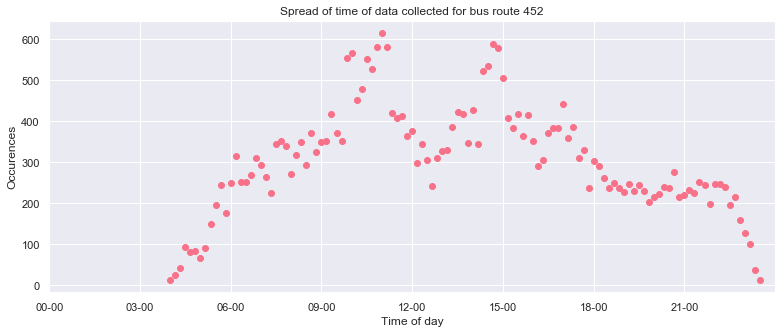

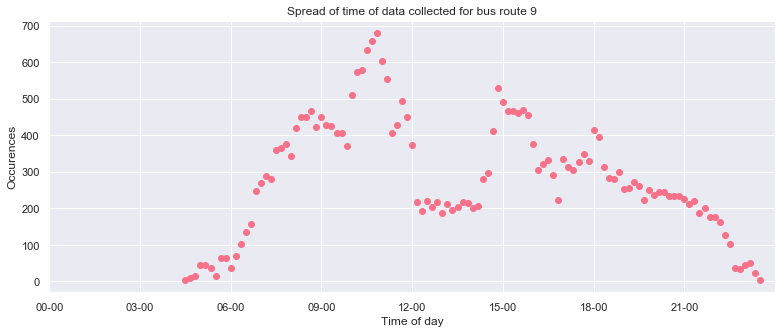

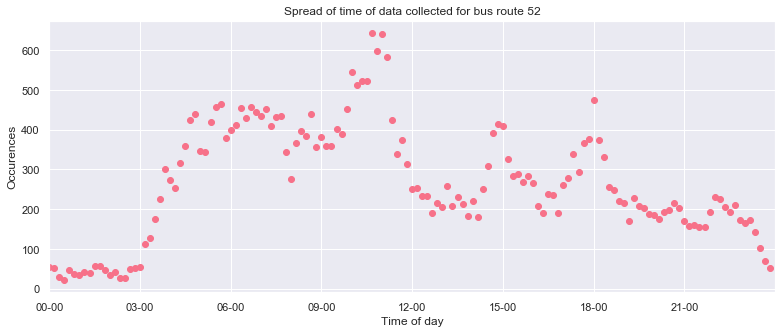

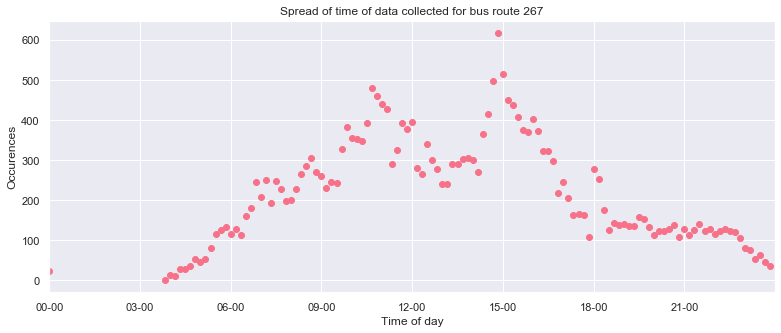

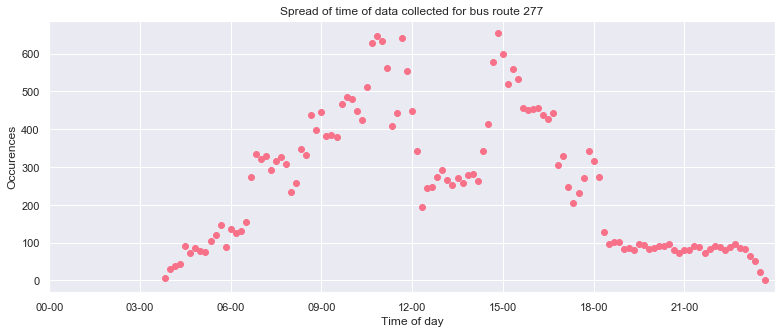

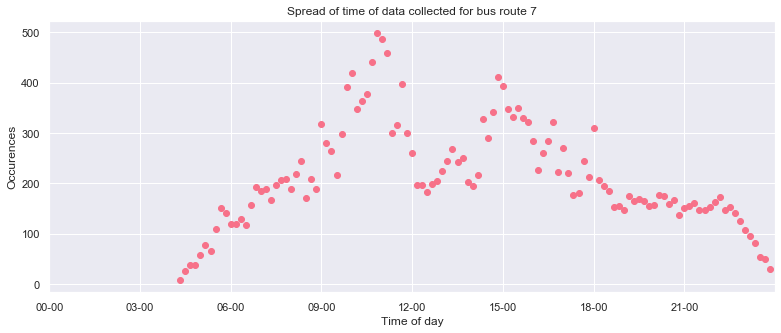

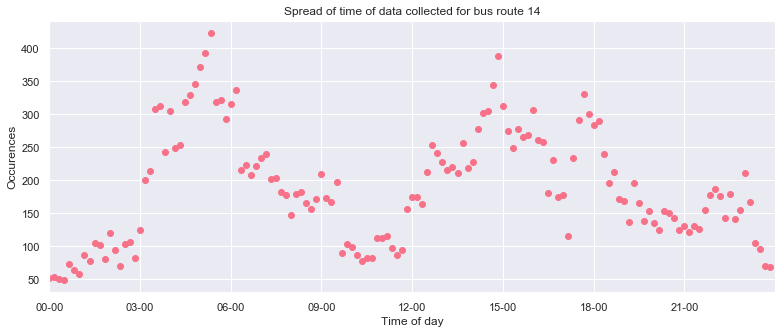

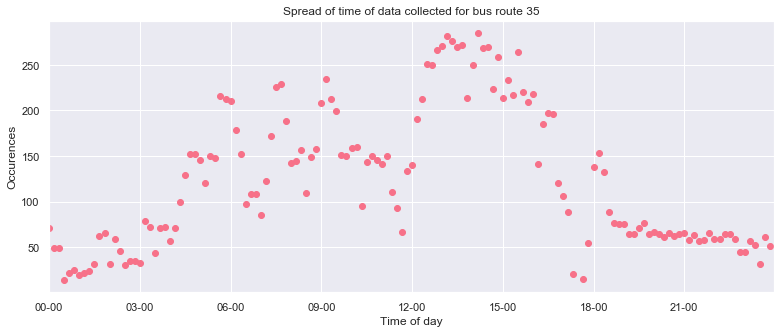

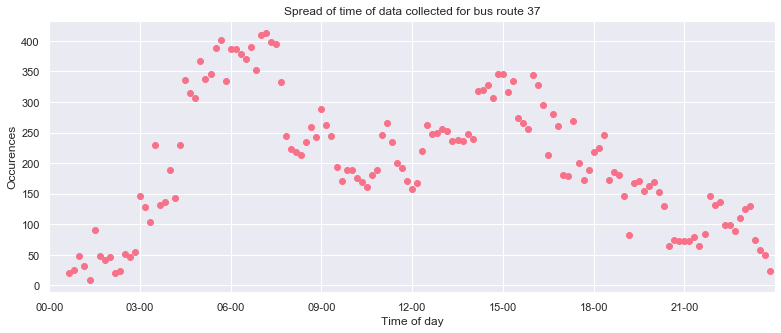

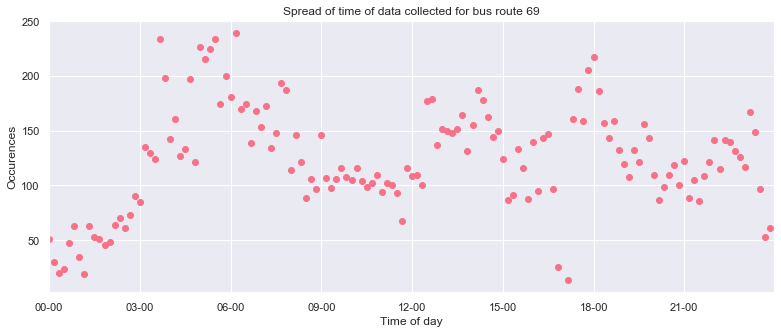

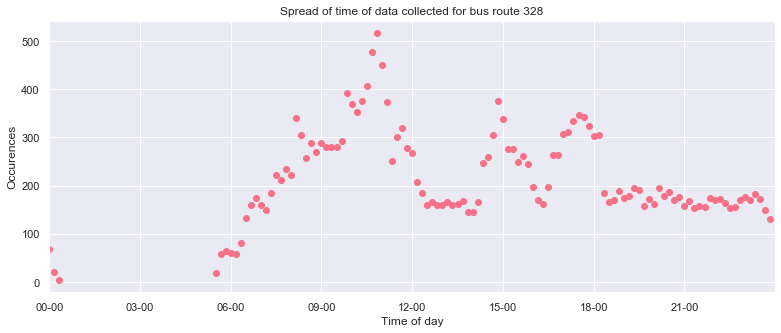

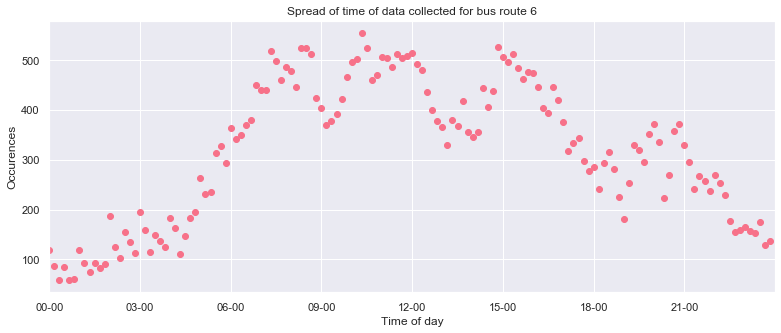

In [7]:
for route in routes:
    spread_of_time(data[route], route)

In [8]:
def spread_of_day_of_week(df, route):

    day_of_week = [x[:10] for x in df['expected_arrival']]
    day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

    day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
    for_aggr = df.assign(day_of_week = day_of_week)
    for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
    ax.set_title("Spread of days of the week for data collected for route {}".format(route))
    ax.set_ylim(0)
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Occurences")
    plt.show()

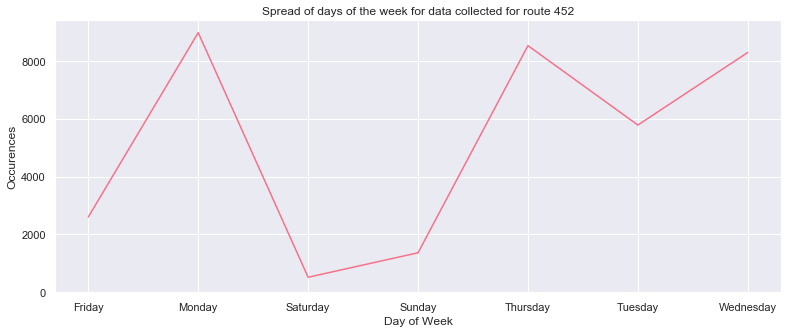

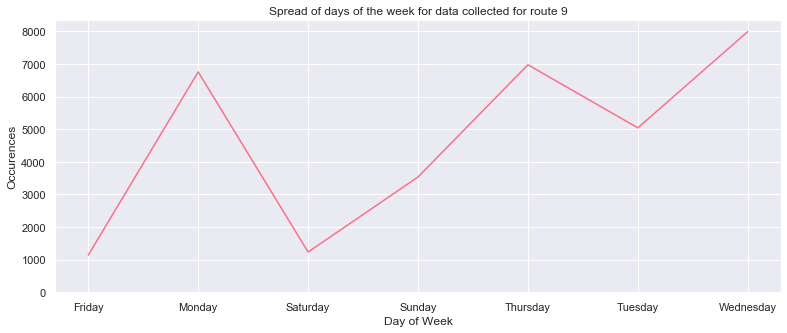

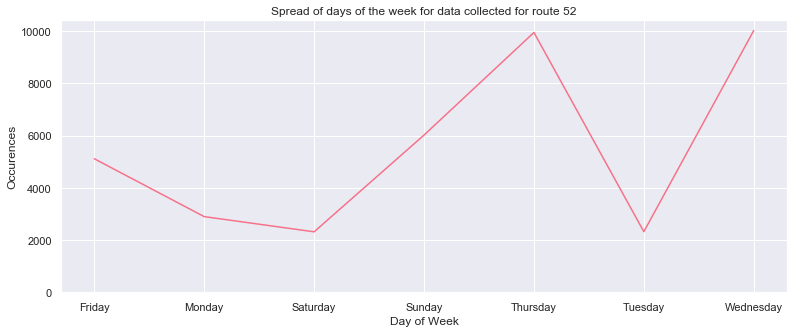

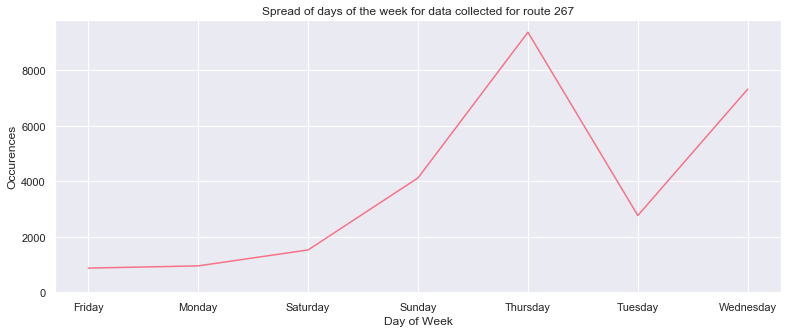

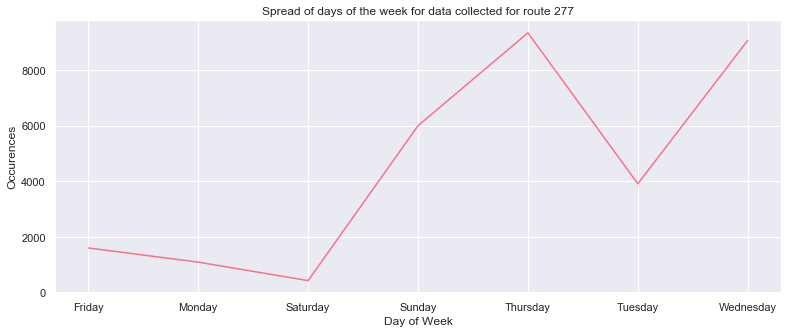

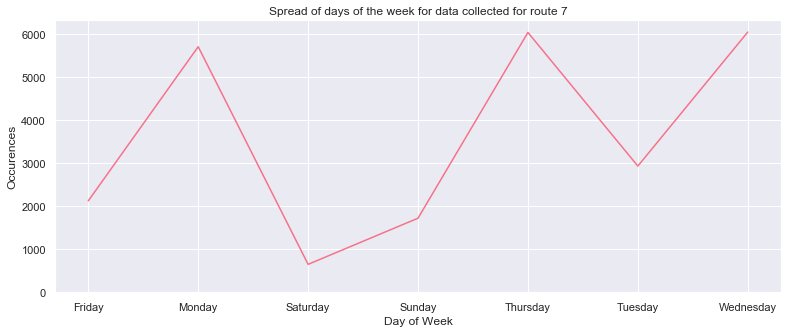

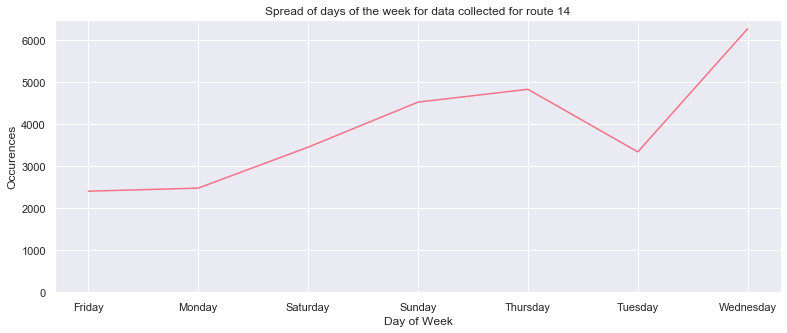

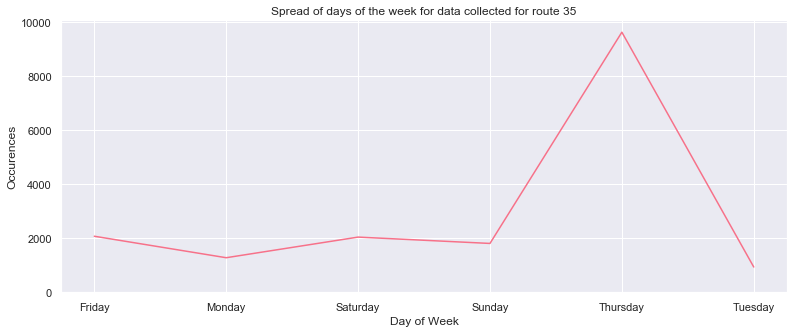

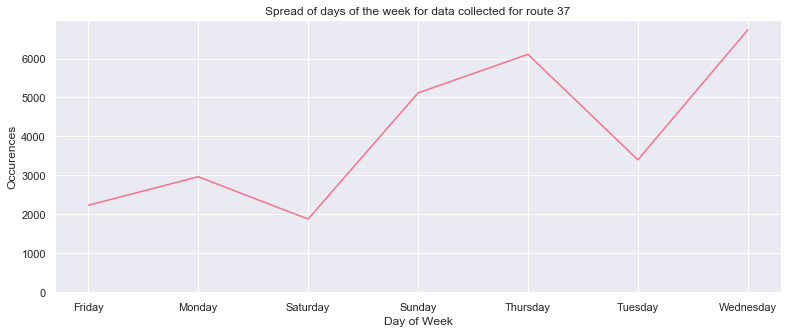

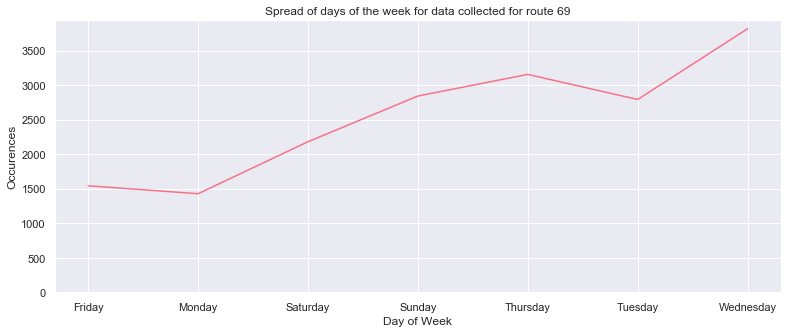

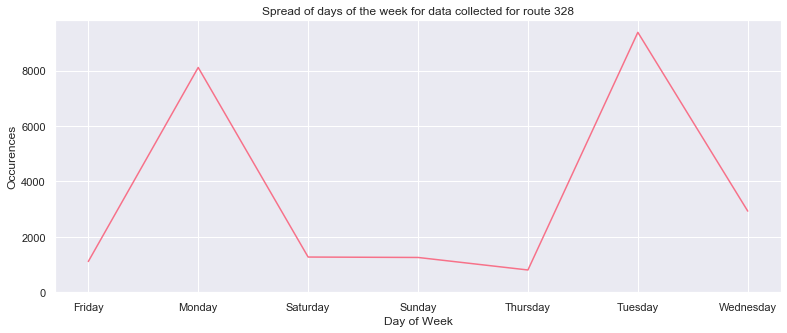

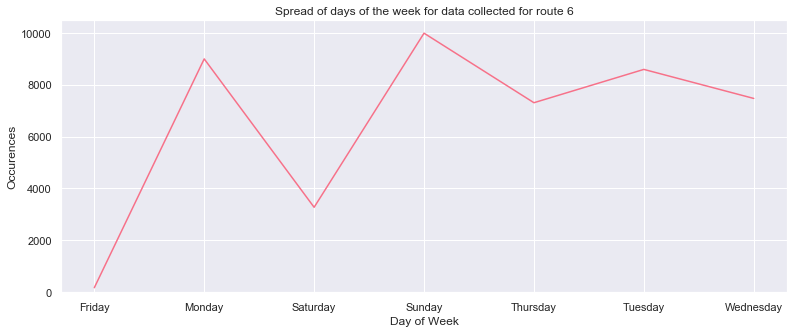

In [9]:
# Want x axis to have day of week in order from Monday - Sunday
for route in routes:
    spread_of_day_of_week(data[route], route)

## Effect of Time of Day on journey times

In [64]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time
    
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

In [65]:
def get_times_between_two_stops(stop_a, stop_b, b_id):
    
    """
    journey_times 
        - is a list of all journey times for a bus from stop a to stop b
    time_of_day_grouped 
        - is a list of lists where each sublist represents a time period of the day
        - each sublist contains the journey times for a bus for that time period
    labels
        - is a list of all colour codes for every journey from stop a to stop b
        - e.g. [1,3,2] represents 3 journeys, where the 1st journey was in the time period 03-06
    """

    journey_times = []
    time_of_day_grouped = [[] for i in range (0, 8)]
    labels = []

    a = time.time()
    for i, journey in stop_a.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
        match_id = bus_id + '_' + b_id + '_' + date + '_' + direction + '_'
        start = convert_time_to_datetime(journey['expected_arrival'])
        for j, match in stop_b.iterrows():
            [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
            end = convert_time_to_datetime(match['expected_arrival'])
            if match['vehicle_id'].startswith(match_id):
                # Error in some of the data where trip num doesn't match so need to check that the travel time
                # is within a reasonable time period
                
                # TODO: Need to make a note of how long a journey time I'm giving these journeys between bus stops
                # Should decide how many bus stops back I should look to predict journey times of a bus
                # E.g. if All Souls Avenue is 7 stops behind Nottinghill Gate Station, I make it standard for all predictions
                # Again could use this as another hyparameter -> see how many stations back I can go before it becomes inaccurate?
                
                if (end - start < dt.timedelta(minutes = 40)) & (end - start > dt.timedelta(minutes = 0)):
                    diff = end - start
                    journey_times.append(diff)
                    section_of_day = get_time_of_day_group(match['expected_arrival'])
                    labels.append(section_of_day)
                    flt = diff.total_seconds() / 60
                    time_of_day_grouped[section_of_day].append(flt)
                    break

    print("Time taken: ", (time.time() - a))
    for i, group in enumerate(time_of_day_grouped):
        if len(group) == 0:
            time_of_day_grouped[i].append(np.nan)
    
    return journey_times, time_of_day_grouped, labels

In [66]:
def calc_info_for_graphs(journey_times):
    """
    travel_times 
        - is a list of all journey times for a bus from stop a to stop b converted into minutes
    avg_time
        - is the average amount of time for a journey from stop a to stop b across all time periods (minutes)
    counts
        - is a list of the number of times each journey time occurs
        - e.g. a journey time of 16 minutes may occur 2 times.
    """
    
    travel_times = [(time.total_seconds() / 60) for time in journey_times]
    avg_time = sum(travel_times) / len(travel_times)
    counts = [journey_times.count(elem) for elem in journey_times]
    return travel_times, avg_time, counts

In [67]:
def graph_travel_times(travel_times, avg_time, counts, stop_a, stop_b, route):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.scatter(travel_times, counts)
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {}".format(route, stop_a, stop_b))
    ax.legend()
    plt.show()
    
def graph_travel_by_time_of_day(route, stop_a, stop_b, travel_times, counts, labels, avg_time):
    fig, ax = plt.subplots(figsize=(15,6))
    sctr = ax.scatter(travel_times, counts, c=labels, cmap=matplotlib.colors.ListedColormap(cs))
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    ax.legend()

    # Can't get ticks to show properly on the colour bar maybe because there is no data for 00-03?
    cbar = fig.colorbar(sctr)
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
    cbar.set_ticklabels(colour_to_time_label)
    cbar.ax.set_title("Time of day")

    plt.show()

def graph_travel_by_time_of_day_2(time_of_day_grouped, avg_time, route, stop_a, stop_b):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Travel Time (minutes)")

    for x, y in zip(colour_to_time_label, time_of_day_grouped):
        ax.scatter([x] * len(y), y)

    ax.plot(colour_to_time_label, [avg_time] * len(colour_to_time_label), 'k--', label='average time')
    ax.set_xticklabels(colour_to_time_label)
    ax.legend()
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    plt.show()

###  Average time taken for a bus to travel from "Battersea Park Station" to "Vauxhall Bus Station" (inbound) for bus 452

In [68]:
b_452 = data["452"]
vauxhall = b_452.loc[(b_452['bus_stop_name'] == 'Vauxhall Bus Station') & (b_452['direction'] == 'in')]
[_, vauxhall_id, _, _, _] = vauxhall.iloc[0]['vehicle_id'].split('_')
print(vauxhall.shape)
print(vauxhall_id)
vauxhall.head()

(394, 5)
490000247G1


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
11,Vauxhall Bus Station,2020-04-02 17:07:31,20189_490000247G1_2020-04-02_in_2,2020-04-02 16:49:18,in
48,Vauxhall Bus Station,2020-03-30 05:52:51,20191_490000247G1_2020-03-30_in_0,2020-03-30 05:28:43,in
76,Vauxhall Bus Station,2020-03-30 07:11:46,20310_490000247G1_2020-03-30_in_0,2020-03-30 06:43:43,in
151,Vauxhall Bus Station,2020-04-02 22:51:27,20199_490000247G1_2020-04-02_in_8,2020-04-02 22:51:37,in
292,Vauxhall Bus Station,2020-04-02 22:39:01,20278_490000247G1_2020-04-02_in_7,2020-04-02 22:36:37,in


In [69]:
battersea_prk_st = b_452.loc[(b_452['bus_stop_name'] == 'Battersea Park Station') & (b_452['direction'] == 'in')]
[_, battersea_prk_st_id, _, _, _] = battersea_prk_st.iloc[0]['vehicle_id'].split('_')
print(battersea_prk_st.shape)
print(battersea_prk_st_id)
battersea_prk_st.head()

(410, 5)
490G01016A


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
12,Battersea Park Station,2020-04-02 13:18:42,20189_490G01016A_2020-04-02_in_0,2020-04-02 13:16:44,in
13,Battersea Park Station,2020-04-01 10:27:00,20271_490G01016A_2020-04-01_in_0,2020-04-01 10:26:42,in
34,Battersea Park Station,2020-04-01 09:53:39,20196_490G01016A_2020-04-01_in_0,2020-04-01 09:53:03,in
37,Battersea Park Station,2020-04-06 07:36:56,20314_490G01016A_2020-04-06_in_1,2020-04-06 07:27:02,in
84,Battersea Park Station,2020-04-02 05:41:12,20193_490G01016A_2020-04-02_in_0,2020-04-02 05:34:44,in


In [70]:
journey_times_bv452, time_of_day_grouped_bv452, labels_bv452 = get_times_between_two_stops(battersea_prk_st, vauxhall, vauxhall_id)
travel_times_bv452, avg_time_bv452, counts_bv452 = calc_info_for_graphs(journey_times_bv452)
print("Average travel time from Battersea Park Station to Vauxhall Bus Station is {} minutes".format(avg_time_bv452))

Time taken:  20.917054891586304
Average travel time from Battersea Park Station to Vauxhall Bus Station is 14.583976124885224 minutes


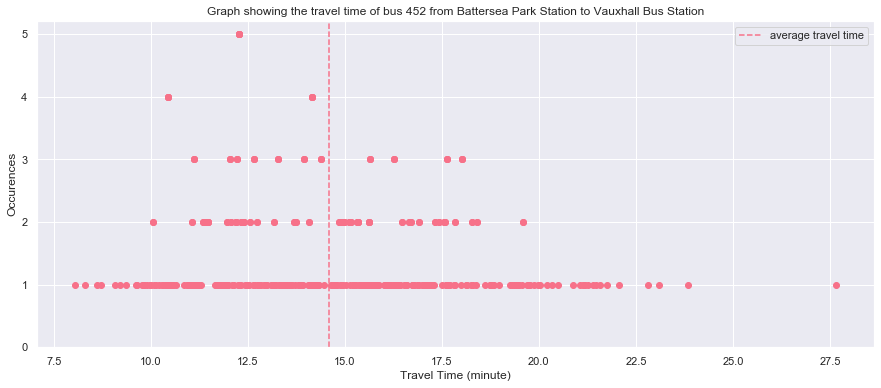

In [71]:
graph_travel_times(travel_times_bv452, avg_time_bv452, counts_bv452, "Battersea Park Station", "Vauxhall Bus Station", "452")

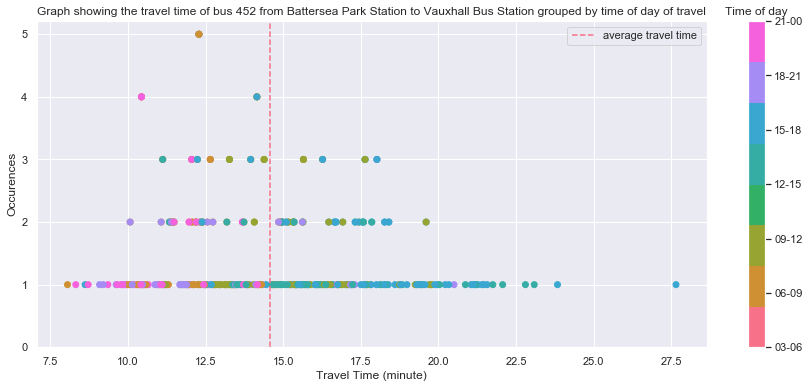

In [72]:
# labels for colour bar don't match because there is no information for 00-03
graph_travel_by_time_of_day("452", "Battersea Park Station", "Vauxhall Bus Station", travel_times_bv452, counts_bv452, labels_bv452, avg_time_bv452)

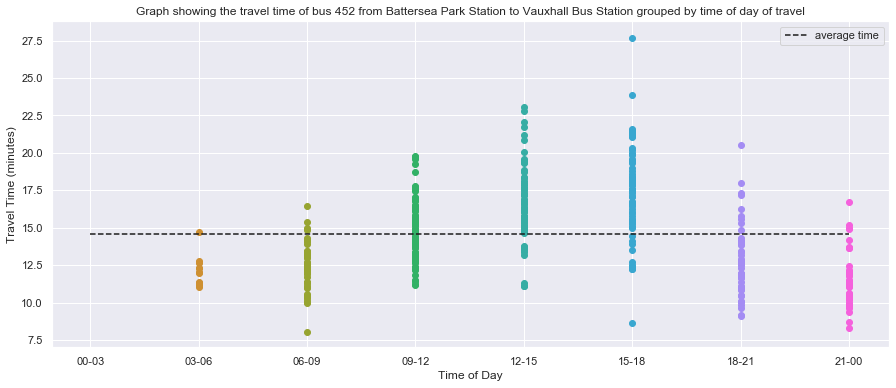

In [73]:
graph_travel_by_time_of_day_2(time_of_day_grouped_bv452, avg_time_bv452, "452", "Battersea Park Station", "Vauxhall Bus Station")

### Average time taken for a bus to travel from "All Souls Avenue" to "Nottinghill Gate Station" (outbound) for bus 52

In [74]:
b_52 = data["52"]
ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'out')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)
ntg_stn.head()

(568, 5)
490000167G


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
106,Notting Hill Gate Station,2020-03-11 10:51:36,10805_490000167G_2020-03-11_out_0,2020-03-11 10:51:46,out
222,Notting Hill Gate Station,2020-04-01 20:38:13,11741_490000167G_2020-04-01_out_2,2020-04-01 20:33:12,out
310,Notting Hill Gate Station,2020-04-05 15:45:34,10627_490000167G_2020-04-05_out_0,2020-04-05 15:41:18,out
385,Notting Hill Gate Station,2020-04-02 10:17:57,19407_490000167G_2020-04-02_out_3,2020-04-02 09:55:17,out
495,Notting Hill Gate Station,2020-04-01 11:46:02,10509_490000167G_2020-04-01_out_0,2020-04-01 11:36:42,out


In [75]:
all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'out')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)
all_souls_avn.head()

(543, 5)
490003256N


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,All Souls Avenue,2020-04-05 16:04:21,10292_490003256N_2020-04-05_out_0,2020-04-05 16:02:45,out
70,All Souls Avenue,2020-04-02 19:46:21,11741_490003256N_2020-04-02_out_2,2020-04-02 19:46:08,out
75,All Souls Avenue,2020-04-02 08:19:56,19643_490003256N_2020-04-02_out_2,2020-04-02 08:16:45,out
104,All Souls Avenue,2020-04-06 05:22:11,11473_490003256N_2020-04-06_out_0,2020-04-06 05:20:17,out
128,All Souls Avenue,2020-03-27 08:31:28,19667_490003256N_2020-03-27_out_0,2020-03-27 08:11:14,out


In [76]:
journey_times_na52, time_of_day_grouped_na52, labels_na52 = get_times_between_two_stops(all_souls_avn, ntg_stn, ntg_stn_id)
travel_times_na52, avg_time_na52, counts_na52 = calc_info_for_graphs(journey_times_na52)
print("Average travel time between from All Souls Avenue to Nottinghill Gate Station is {} minutes".format(avg_time_na52))

Time taken:  34.2052800655365
Average travel time between from All Souls Avenue to Nottinghill Gate Station is 15.170405310971352 minutes


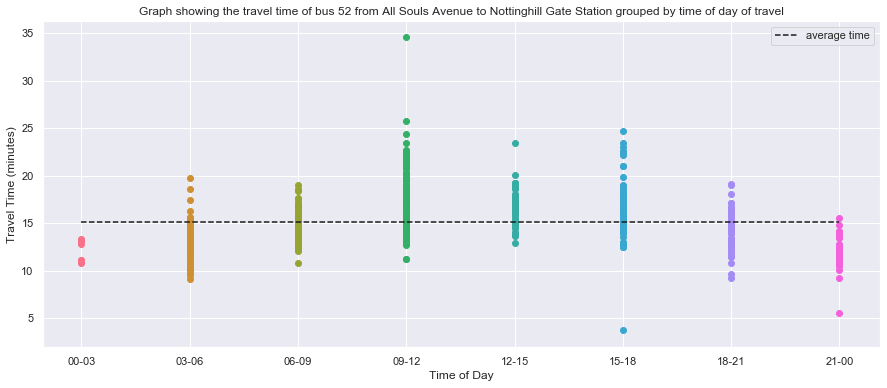

In [77]:
graph_travel_by_time_of_day_2(time_of_day_grouped_na52, avg_time_na52, "52", "All Souls Avenue", "Nottinghill Gate Station")

### Average time taken for a bus to travel from "Warwick Avenue Station" to "Trafalgar Square" (inbound) for bus 6

In [38]:
b_6 = data["6"]
warwick_avn = b_6.loc[(b_6['bus_stop_name'] == 'Warwick Avenue Station') & (b_6['direction'] == 'in')]
[_, warwick_avn_id, _, _, _] = warwick_avn.iloc[0]['vehicle_id'].split('_')
print(warwick_avn.shape)
print(warwick_avn_id)
warwick_avn.head()

(616, 5)
490000253H


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
28,Warwick Avenue Station,2020-04-25 10:08:40,10275_490000253H_2020-04-25_in_0,2020-04-25 10:06:38,in
59,Warwick Avenue Station,2020-04-25 10:13:14,10274_490000253H_2020-04-25_in_0,2020-04-25 10:13:07,in
154,Warwick Avenue Station,2020-04-25 10:21:14,19403_490000253H_2020-04-25_in_0,2020-04-25 10:21:34,in
224,Warwick Avenue Station,2020-04-25 10:29:16,19670_490000253H_2020-04-25_in_0,2020-04-25 10:17:25,in
293,Warwick Avenue Station,2020-04-25 10:37:58,10631_490000253H_2020-04-25_in_0,2020-04-25 10:37:39,in


In [39]:
trafalgar_sqr = b_6.loc[(b_6['bus_stop_name'] == 'Trafalgar Square') & (b_6['direction'] == 'in')]
[_, trafalgar_sqr_id, _, _, _] = trafalgar_sqr.iloc[0]['vehicle_id'].split('_')
print(trafalgar_sqr.shape)
print(trafalgar_sqr_id)
trafalgar_sqr.head()

(583, 5)
490013767B


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
37,Trafalgar Square,2020-04-25 10:07:12,9976_490013767B_2020-04-25_in_0,2020-04-25 10:05:00,in
156,Trafalgar Square,2020-04-25 10:21:05,19409_490013767B_2020-04-25_in_0,2020-04-25 10:17:56,in
217,Trafalgar Square,2020-04-25 10:26:56,10275_490013767B_2020-04-25_in_0,2020-04-25 10:26:16,in
252,Trafalgar Square,2020-04-25 10:32:56,10274_490013767B_2020-04-25_in_0,2020-04-25 10:28:50,in
315,Trafalgar Square,2020-04-25 10:38:26,19403_490013767B_2020-04-25_in_0,2020-04-25 10:33:30,in


In [40]:
journey_times_wt6, time_of_day_grouped_wt6, labels_wt6 = get_times_between_two_stops(warwick_avn, trafalgar_sqr, trafalgar_sqr_id)
travel_times_wt6, avg_time_wt6, counts_wt6 = calc_info_for_graphs(journey_times_wt6)
print("Average travel time between Warwick Avenue Station and Trafalgar Square is {} minutes".format(avg_time_wt6))

Time taken:  24.467293977737427
Average travel time between Warwick Avenue Station and Trafalgar Square is 20.482149712092134 minutes


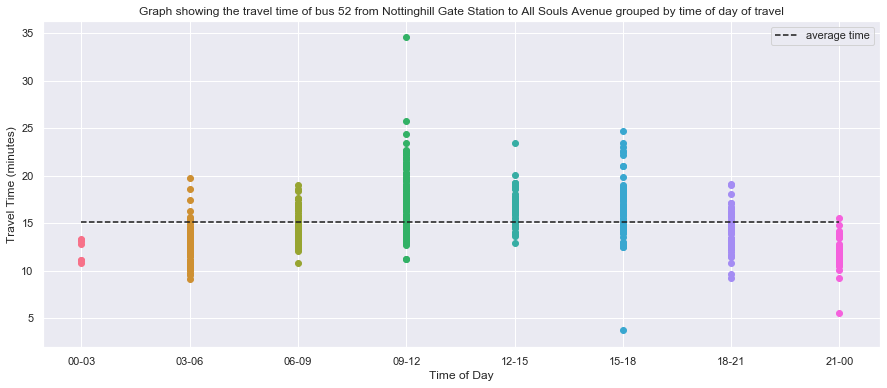

In [41]:
graph_travel_by_time_of_day_2(time_of_day_grouped_na52, avg_time_na52, "52", "Nottinghill Gate Station", "All Souls Avenue")

## Aggregate all the travel times for 2 stops that are a set number of stops apart (say 10 stops apart) and plot as above to see a trend in the time of day -> then can use this to decide weightings for times of day

e.g. 09-12 tends to have higher journey times, so if trying to predict a journey time during this period, maybe have a wider range of times to consider i.e. moer likely to consider outliers than say 00-03?